# CookieCutter
This app predicts the total calories given a string of recipe ingredients.

Training data was scraped from AllRecipes.com

Input of web app is a string of recipe ingredents in the following format:
* '2 cups flour; 1 cup sugar; 1/2 cup butter; 1 teaspoon salt'

## Import packages

In [156]:
import numpy as np
import pandas as pd
import re

## Import functions

In [157]:
def multireplace(string, replacements, ignore_case=False):
    """
    Given a string and a replacement map, it returns the replaced string.
    :param str string: string to execute replacements on
    :param dict replacements: replacement dictionary {value to find: value to replace}
    :param bool ignore_case: whether the match should be case insensitive
    :rtype: str
    """
    # If case insensitive, we need to normalize the old string so that later a replacement
    # can be found. For instance with {"HEY": "lol"} we should match and find a replacement for "hey",
    # "HEY", "hEy", etc.
    if ignore_case:
        def normalize_old(s):
            return s.lower()

        re_mode = re.IGNORECASE

    else:
        def normalize_old(s):
            return s

        re_mode = 0

    replacements = {normalize_old(key): val for key, val in replacements.items()}
    
    # Place longer ones first to keep shorter substrings from matching where the longer ones should take place
    # For instance given the replacements {'ab': 'AB', 'abc': 'ABC'} against the string 'hey abc', it should produce
    # 'hey ABC' and not 'hey ABc'
    rep_sorted = sorted(replacements, key=len, reverse=True)
    rep_escaped = map(re.escape, rep_sorted)
    
    # Create a big OR regex that matches any of the substrings to replace
    pattern = re.compile("|".join(rep_escaped), re_mode)
    
    # For each match, look up the new string in the replacements, being the key the normalized old string
    return pattern.sub(lambda match: replacements[normalize_old(match.group(0))], string)

def string_replace(x):
    new_string = re.sub(' {2,}', ' ', x).replace("\n", ";").replace("; ;", ";")
#    new_string = new_string.split(';')
    return(new_string)

def get_ingredients (x):
    ing_regex = ('(\d+/*\d*\s*\d*/*\d*)\s(\w+\s*.*?);')
    all_ing = re.findall(ing_regex, x)
    return(all_ing)

def get_quantity(x):
    quantity = [y[0] for y in x] # use for df
    units_with_ingredient = [y[1] for y in x]
    df_of_units = pd.DataFrame({'quantity':quantity, 'ingredient':units_with_ingredient})
    return (df_of_units)

def match_uids(originaldf, longdf):
    for row in range(0, len(originaldf)):
        longdf[row]['recipe_key']=originaldf['recipe_key'][row]
        longdf[row]['calPerServing']=originaldf['calPerServing'][row]
        longdf[row]['totalCal']=originaldf['totalCal'][row]
        longdf[row]['servings']=originaldf['servings'][row]
        longdf[row]['name']=originaldf['name'][row]
    return(longdf)

def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    import string
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer
    wnl = WordNetLemmatizer()
    
    def lemmatize(string):
        for word in re.findall(r"[a-z]+", string):
            string = string.replace(word, wnl.lemmatize(word, 'n') if 's' in word[-3:] else word)
        return string
    
    unit_stopwords = ['dash','pinch','teaspoon','tablespoon','fluid','cup','pint','quart','ounce','oz','pound','rack',
                'small','medium','large','crushed','grated','skinless','boneless','melted','fresh',
                'diced','minced','thinly','dry','dried','halved','taste','frying','lean','drained','jars','grated'
                'clove','slice','eaches','whole','cube','thick','unit','freshly','finely','splash',
                'semisweet','chip','extract','spread','powder','room','temperature','brown','cooking','yolk','ground',
                'package','mix','cake','plain','goody','light','wheat','piece','substitute','mini','kosher','crispy',
                'minature','chunk','dark','bit','square','boiling','bag','crumb','popsicle','stick','zest','cereal',
                'bar','tart','nib','tennessee','turbinado','baking','pack','spice','moist','miniarature','crunchy',
                'morsel','nugget','candy','crisp','super','fine','decoration','sucralose','puree','pureed','rainbow',
                'cut','frozen','broken','round','concentrate','miniature','cooky','virgin','dusting','half','baby',
                'food','jar','seedless','container','box','granule','filling','cold','super','ripe','moisture',
                'packet','instant','mint','ripe','sea','coarse','fun','size','funsize','bulk','chopped','torn',
                'inch','shell','quality','strap','bittersweet','gallon','pure','cane','liquid','drop','hard','yellow'
                'black','strap','kiss','protein','supplement','dessert','topping']
    
    # Remove anything in parenthesis
    mess = re.sub(r"\([^\)]+\)", '', mess)
    # Make everything lowercase
    mess = mess.lower()
    # Remove non-word punctuation
    mess =' '.join(re.findall(r"[-,''\w]+", mess)) # This leaves some commas as a character #
    mess = re.sub(r"\,", ' ', mess)
    # Remove hypenated words
    mess = re.sub(r"(?=\S*['-])([a-zA-Z'-]+)",'',mess) # remove hypenated words
    # Remove punctuation and numbers
    mess = ''.join([i for i in mess if not i.isdigit()])
    # Remove plurals
    mess = lemmatize(mess)
    #clean excess whitespace
    mess = re.sub(r"\s+", ' ', mess).strip()
    # Remove stopwords
    mess = [word for word in mess.split() if word.lower() not in stopwords.words('english')]
    mess  = [word for word in mess if word.lower() not in unit_stopwords]
    mess = ' '.join(mess)
    return(mess.split())

def test_noun(tokens):  
    import nltk
    tagged = nltk.pos_tag(tokens)
    return([token[0] for token in tagged if token[1] in ['NN',]])

def convert_fractions (quantity):
    from fractions import Fraction
    return float(sum(Fraction(s) for s in quantity.split()))

def join_strings(mess):
    # Keep integers
    mess = ' '.join(mess)

    if len(mess)>=1:
        return(mess)
    else:
        return('')

## Clean ingredient text string

In [158]:
# Load data
#df = pd.read_csv('dataset_allrecipes-test-v3_2020-06-02_01-37-25-797.csv') # Dinner recipes
# df = pd.read_csv('dataset_allrecipes-test-v4_choco_chip_cookie_2020-06-06_22-41-30-703.csv') # Chocolate chip recipes

df = pd.read_csv('dataset_allrecipes-test-v4_all-cookies_2020-06-06_22-20-57-219.csv') # all cookie recipes
# df2 = pd.read_csv('dataset_allrecipes-test-v4_all-ingredients_2020-06-06_22-40-04-991.csv') # all ingredient recipes
# df = pd.concat([df,df2]).drop_duplicates() # combine all cookie and ingredient recipes

# Clean column names
df.rename(columns = {'calories':'calPerServing', 'cook':'cookTime', 'prep':'prepTime','ready in':'totalTime'}, inplace = True) 

# Create unique id
df['recipe_key'] = df['url'].apply(lambda x:int(re.findall(r"\d+", x)[0]))

# Calculate total calories per recipe
df['totalCal'] = df['calPerServing']*df['servings']
df = df[(df['servings']<=64) & (df['servings']>=12) & (df['totalCal']<10000)] #filter for recipes with 12-64 servings and < 10,000 total calories
df.reset_index(inplace=True, drop=True)

# Clean ingredient text
dict_unicode = {'\u2009': '', '½':' 1/2', '⅓':'1/3', '⅔':'2/3', '¼':'1/4', '¾':'3/4', '⅕':'1/5', 
                '⅖':'2/5', '⅗':'3/5', '⅘':'4/5', '⅙':'1/6', '⅚':'5/6', '⅐':'1/7', '⅛':'1/8', 
                '⅜':'3/8', '⅝':'5/8', '⅞':'7/8', '⅑':'1/9', '⅒':'1/10'}
df['recipeIngredient'] = [item + ';' for item in df['recipeIngredient']] # add semicolon at end of each string for easier regex filtering
df['recipeIngredient'] = [multireplace(x, dict_unicode) for x in df['recipeIngredient']] # replace unicode characters
df['recipeIngredient'] = [string_replace(x) for x in df['recipeIngredient']] # remove whitespace
ing = [get_ingredients(x) for x in df['recipeIngredient']] # separate ingredients into list of list of tupules of ingredient strings

df_ing = [get_quantity(x) for x in ing] # separate units of measure and ingredients & creates a pandas dataframe for each recipe

clean_df = match_uids(df, df_ing) # pull unique id, calorie (outcome variable), number of servings, and number of ingredients from original dataframe
clean_df = pd.concat(clean_df) # concat list of pandas dataframes into one dataframe
clean_df['quantity'] = [convert_fractions(x) for x in clean_df['quantity']] # convert fractions into integers

# Create multiIndex / hierarchical Dataframe
# clean_df = clean_df.reset_index(drop=True)
clean_df = clean_df.reset_index()


## Normalize quantity of ingredients to grams

In [159]:
# save as csv for web app
# clean_df.to_csv('clean_df.csv')

# Convert measurements to normalized unit  (1 Unit= 1 grams)
clean_df['unit'] = np.where(clean_df.ingredient.str.contains("dash"), .3,
            np.where(clean_df.ingredient.str.contains("pinch"), .6,
            np.where(clean_df.ingredient.str.contains("teaspoon"), 5, 
            np.where(clean_df.ingredient.str.contains("tablespoon"), 3,
            np.where(clean_df.ingredient.str.contains("fluid"), 30,
            np.where(clean_df.ingredient.str.contains("cup"), 240, 
            np.where(clean_df.ingredient.str.contains("pint"), 473,
            np.where(clean_df.ingredient.str.contains("quart"), 980,
            np.where(clean_df.ingredient.str.contains("ounce"), 28,
            np.where(clean_df.ingredient.str.contains("oz"), 28, 
            np.where(clean_df.ingredient.str.contains("pound"), 454,
            np.where(clean_df.ingredient.str.contains("rack"), 908,
            np.where(clean_df.ingredient.str.contains("small"), 50,
            np.where(clean_df.ingredient.str.contains("medium"), 60,
            np.where(clean_df.ingredient.str.contains("large"), 70,
            3))))))))))))))) 

# Use bigrams

In [ ]:
# Only remove units and not other unnecessary ingredient words
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    import string
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer
    wnl = WordNetLemmatizer()
    
    def lemmatize(string):
        for word in re.findall(r"[a-z]+", string):
            string = string.replace(word, wnl.lemmatize(word, 'n') if 's' in word[-3:] else word)
        return string
    
    unit_stopwords = ['dash','pinch','teaspoon','tablespoon','fluid','cup','pint','quart','ounce','oz','pound','rack',
                'small','medium','large','semisweet']
#     unit_stopwords = ['dash','pinch','teaspoon','tablespoon','fluid','cup','pint','quart','ounce','oz','pound','rack',
#             'small','medium','large','crushed','grated','skinless','boneless','melted','fresh',
#             'diced','minced','thinly','dry','dried','halved','taste','frying','lean','drained','jars','grated'
#             'clove','slice','eaches','whole','cube','thick','unit','freshly','finely','splash',
#             'semisweet','chip','extract','spread','powder','room','temperature','brown','cooking','yolk','ground',
#             'package','mix','cake','plain','goody','light','wheat','piece','substitute','mini','kosher','crispy',
#             'minature','chunk','dark','bit','square','boiling','bag','crumb','popsicle','stick','zest','cereal',
#             'bar','tart','nib','tennessee','turbinado','baking','pack','spice','moist','miniarature','crunchy',
#             'morsel','nugget','candy','crisp','super','fine','decoration','sucralose','puree','pureed','rainbow',
#             'cut','frozen','broken','round','concentrate','miniature','cooky','virgin','dusting','half','baby',
#             'food','jar','seedless','container','box','granule','filling','cold','super','ripe','moisture',
#             'packet','instant','mint','ripe','sea','coarse','fun','size','funsize','bulk','chopped','torn',
#             'inch','shell','quality','strap','bittersweet','gallon','pure','cane','liquid','drop','hard','yellow'
#             'black','strap','kiss','protein','supplement','dessert']
    # Remove anything in parenthesis
    mess = re.sub(r"\([^\)]+\)", '', mess)
    # Make everything lowercase
    mess = mess.lower()
    # Remove non-word punctuation
    mess =' '.join(re.findall(r"[-,''\w]+", mess)) # This leaves some commas as a character #
    mess = re.sub(r"\,", ' ', mess)
    # Remove hypenated words
    mess = re.sub(r"(?=\S*['-])([a-zA-Z'-]+)",'',mess) # remove hypenated words
    # Remove punctuation and numbers
    mess = ''.join([i for i in mess if not i.isdigit()])
    # Remove plurals
    mess = lemmatize(mess)
    #clean excess whitespace
    mess = re.sub(r"\s+", ' ', mess).strip()
    # Remove stopwords
    mess = [word for word in mess.split() if word.lower() not in stopwords.words('english')]
    mess  = [word for word in mess if word.lower() not in unit_stopwords]
    mess = ' '.join(mess)
    return(mess)
#     return(mess.split())

In [ ]:
test_df = clean_df.copy()

In [ ]:
# Tokenization = convert text string into list of tokens, or words, we want (i.e., cleaned version of words).
import string
from nltk.corpus import stopwords
test_df['ingredient']=[text_process(x) for x in test_df['ingredient']]

# Total quantity of each ingredient needed for recipe (grams* quantity) and condense into a list.
test_df['norm_quant'] = round(test_df['unit']*test_df['quantity'])
test_df['norm_quant'] = test_df['norm_quant'].astype(int)
test_df.head()

In [ ]:
# Test data using ngrams to identify words (ie. baking soda)
from nltk import ngrams

bigram = [list(ngrams(words.lower().split(),2)) for words in test_df['ingredient']]
# trigram=list(ngrams(Sentences.lower().split(),3))
# fourgram=list(ngrams(Sentences.lower().split(),4))

In [ ]:
all_bigrams = [i for sub in bigram for i in sub] # combine list of lists of tuples to one list

In [ ]:
[nltk.pos_tag(words) for words in all_bigrams]

In [ ]:
#function to filter for ADJ/NN bigrams
def rightTypes(ngram):
    from nltk.corpus import stopwords
    en_stopwords = set(stopwords.words('english'))

    for word in ngram:
        if word in en_stopwords or word.isspace():
            return False
    acceptable_types = ('NN','VBG')
    second_type = ('NN')
    tags = nltk.pos_tag(ngram)
    if tags[0][1] in acceptable_types and tags[1][1] in second_type:
        return True
    else:
        return False

In [ ]:
bigram_df = pd.DataFrame(all_bigrams,columns=['first','second'])
bigram_df['bigram'] = bigram_df[['first','second']].apply(tuple, axis=1)
bigram_df['Noun'] = [rightTypes(tokens) for tokens in all_bigrams]
# bigram_df[bigram_df['Noun']]
fdist = nltk.FreqDist(bigram_df[bigram_df['Noun']]['bigram']).most_common(30) # top 30 bigrams
fdist

In [ ]:
# Method 2: Using NLTK Collocations
unlist_comments = [item for items in test_df['ingredient'] for item in items]

import nltk
bigrams = nltk.collocations.BigramAssocMeasures()
bigramFinder = nltk.collocations.BigramCollocationFinder.from_words(unlist_comments)

bigram_freq = bigramFinder.ngram_fd.items()
bigramFreqTable = pd.DataFrame(list(bigram_freq), columns=['bigram','freq']).sort_values(by='freq', ascending=False)
bigramFreqTable

### Count frequency of adjacent words with part of speech filters

In [ ]:
# function to filter for ADJ/NN bigrams
def rightTypes(ngram):
    from nltk.corpus import stopwords
    en_stopwords = set(stopwords.words('english'))

    if '-pron-' in ngram or 't' in ngram:
        return False
    for word in ngram:
        if word in en_stopwords or word.isspace():
            return False
#     acceptable_types = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')
    acceptable_types = ('JJ', 'NN')
#     second_type = ('NN', 'NNS', 'NNP', 'NNPS')
    second_type = ('NN')
    tags = nltk.pos_tag(ngram)
    if tags[0][1] in acceptable_types and tags[1][1] in second_type:
        return True
    else:
        return False

    #filter bigrams
filtered_bi = bigramFreqTable[bigramFreqTable.bigram.map(lambda x: rightTypes(x))]
filtered_bi

In [ ]:
[nltk.pos_tag(words) for words in filtered_bi['bigram']]

In [ ]:
filtered_bi[filtered_bi['freq']>50]

## Tokenize ingredient text

In [160]:
# Tokenization = convert text string into list of tokens, or words, we want (i.e., cleaned version of words).
import string
from nltk.corpus import stopwords
clean_df['ingredient']=[text_process(x) for x in clean_df['ingredient']]

# Total quantity of each ingredient needed for recipe (grams* quantity) and condense into a list.
clean_df['norm_quant'] = round(clean_df['unit']*clean_df['quantity'])
clean_df['norm_quant'] = clean_df['norm_quant'].astype(int)

# One word per ingredient - keep only nouns, join multiple words as one string
clean_df['ingredient'] = [test_noun(tokens) for tokens in clean_df['ingredient']]
clean_df['ingredient'] = [''.join(tokens) for tokens in clean_df['ingredient']]

# Repeat word by normalized quantity
clean_df2 = clean_df.copy()
clean_df2['ingredient'] = clean_df2['ingredient'].astype(str) + ' '
zipped = list(zip(clean_df2['ingredient'], clean_df2['norm_quant']))
inglist = [t[0]*t[1] for t in zipped]
final_df = pd.DataFrame(inglist, columns=['ingredient'])
final_df[['recipe_key','totalCal','calPerServing','name','ingredient_key']] = clean_df[['recipe_key','totalCal','calPerServing','name','index']]

# Create multiIndex / hierarchical Dataframe
tuples = list(zip(*[final_df['recipe_key'],final_df['ingredient_key']]))
index = pd.MultiIndex.from_tuples(tuples, names=['recipe_key', 'ingredient_key'])
final_df.set_index(index,inplace=True)
final_df.head()

ingredient  \
recipe_key ingredient_key                                                      
16212      0               butter butter butter butter butter butter butt...   
           1               sugar sugar sugar sugar sugar sugar sugar suga...   
           2                            water water water water water water    
           3               chocolate chocolate chocolate chocolate chocol...   
           4                                        egg egg egg egg egg egg    

                           recipe_key  totalCal  calPerServing  \
recipe_key ingredient_key                                        
16212      0                    16212    6480.0          162.0   
           1                    16212    6480.0          162.0   
           2                    16212    6480.0          162.0   
           3                    16212    6480.0          162.0   
           4                    16212    6480.0          162.0   

                                                     name  ingredient_key  
recipe_key ingredient_key                                                  
16212      0               Chocolate Mint Candies Cookies               0  
           1               Chocolate Mint Candies Cookies               1  
           2               Chocolate Mint Candies Cookies               2  
           3               Chocolate Mint Candies Cookies               3  
           4               Chocolate Mint Candies Cookies               4

## Process input text for App

In [ ]:
test = '1 cup packed brown sugar; 2 eggs; 1 teaspoon baking soda; 1 teaspoon salt; 1 teaspoon vanilla extract; 2 1/2 cups sifted all-purpose flour; 1/2 cup chopped walnuts; 2 cups semisweet chocolate chips'
servings = 24
test = test + ';' # add semicolon to end of ingredient list for regex
test = string_replace(test) # remove white space
test_ing = get_ingredients(test) # separate ingredients into list of tuples
testdf = get_quantity(test_ing) # separate quantity from words
testdf['quantity'] = [convert_fractions(x) for x in testdf['quantity']]
testdf['unit'] = np.where(testdf.ingredient.str.contains("dash"), .3,
            np.where(testdf.ingredient.str.contains("pinch"), .6,
            np.where(testdf.ingredient.str.contains("teaspoon"), 5, 
            np.where(testdf.ingredient.str.contains("tablespoon"), 3,
            np.where(testdf.ingredient.str.contains("fluid"), 30,
            np.where(testdf.ingredient.str.contains("cup"), 240, 
            np.where(testdf.ingredient.str.contains("pint"), 473,
            np.where(testdf.ingredient.str.contains("quart"), 980,
            np.where(testdf.ingredient.str.contains("ounce"), 28,
            np.where(testdf.ingredient.str.contains("oz"), 28, 
            np.where(testdf.ingredient.str.contains("pound"), 454,
            np.where(testdf.ingredient.str.contains("rack"), 908,
            np.where(testdf.ingredient.str.contains("small"), 50,
            np.where(testdf.ingredient.str.contains("medium"), 60,
            np.where(testdf.ingredient.str.contains("large"), 70,
            1))))))))))))))) 

# Tokenization = convert text string into list of tokens, or words, we want (i.e., cleaned version of words).
import string
from nltk.corpus import stopwords
testdf['ingredient']=[text_process(x) for x in testdf['ingredient']]

# Total quantity of each ingredient needed for recipe (grams* quantity) and condense into a list.
testdf['norm_quant'] = round(testdf['unit']*testdf['quantity'])
testdf['norm_quant'] = testdf['norm_quant'].astype(int)

# One word per ingredient - keep only nouns, join multiple words as one string
testdf['ingredient'] = [test_noun(tokens) for tokens in testdf['ingredient']]
testdf['ingredient'] = ['_'.join(tokens) for tokens in testdf['ingredient']]

# Repeat word by normalized quantity
testdf['ingredient'] = testdf['ingredient'].astype(str) + ' '
zipped = list(zip(testdf['ingredient'], testdf['norm_quant']))
inglist = [t[0]*t[1] for t in zipped]
inglist = ''.join(inglist)

In [ ]:
ingredient_bow_inglist = bow_transformer.transform(inglist) # Transform test dataset to Bag of Words
ingredient_bow_inglist

In [ ]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(ingredient_bow_train,y_train['totalCal'])

predictions = linreg.predict(ingredient_bow_inglist)
predictions

In [ ]:
ingredient_bow_train

# NLP
1) Bag of words

2) TF-IDF (term frequency-inverse document frequency)

3) Combine word weights (from TF-IDF) with quantitative metrics (quantity, serving size), then model based on that

4) Train test split

5) Machine learning model


In [166]:
df.rename(columns = {'recipe_key':'key'}, inplace = True) 
final_df.rename(columns = {'recipe_key':'key'}, inplace = True) 
X_ing = final_df.groupby('recipe_key')['ingredient'].apply(' '.join) # join list of strings into one string per recipe
X_ing = pd.DataFrame(X_ing)
X_ing[['orig_ing','name','servings']] = df.set_index('key')[['recipeIngredient','name','servings']]

y_cal = df.set_index('key')[['totalCal','calPerServing','name']].sort_index().copy()

y_label = df.set_index('key')['totalCal']
X_keys = df.reset_index(drop=True)['key']

from sklearn.model_selection import train_test_split # Train Test Split
key_train, key_test, y_train_label, y_test_label = train_test_split(X_keys, y_label, test_size=0.2, random_state=101) # won't work with multilevel index

X_train = X_ing.loc[key_train]
X_test = X_ing.loc[key_test]
y_train = y_cal.loc[key_train]
y_test = y_cal.loc[key_test]

X_train.sort_index(inplace=True)
X_test.sort_index(inplace=True)
y_train.sort_index(inplace=True)
y_test.sort_index(inplace=True)

X_test.drop([10392, 16571,17337],inplace=True)
y_test.drop([10392, 16571,17337],inplace=True)

print("Training set contains {} recipes in total".format(len(key_train)))
print("Test set contains {} recipes in total".format(len(key_test)))

Training set contains 1836 recipes in total
Test set contains 460 recipes in total


In [ ]:
# Save data as csv
X_train.to_csv('X_train.csv')
X_test.to_csv('X_test.csv')
y_train.to_csv('y_train.csv')
y_test.reset_index().to_csv('y_test.csv')

# NLP - separate steps
#### Bag of words vectorization

In [162]:
from sklearn.feature_extraction.text import CountVectorizer 
bow_transformer = CountVectorizer(analyzer=text_process).fit(X_train['ingredient']) # Bag of Words
print(len(bow_transformer.vocabulary_)) # Print total number of vocab words
print(bow_transformer.get_feature_names()) # Print all words

372
['allspice', 'almond', 'almondbark', 'almondbrickle', 'almondbutter', 'almondflour', 'almondmeal', 'almondmilk', 'almondpaste', 'anise', 'aniseaniseoil', 'aniseoil', 'aniseseed', 'apple', 'applebutter', 'applecinnamongranola', 'applejuice', 'applepeel', 'applepie', 'applesauce', 'apricot', 'apricotfruit', 'apricotjam', 'apricotpreserve', 'avocado', 'bacon', 'bacondice', 'banana', 'bananapudding', 'barley', 'bean', 'berry', 'berrycranberrysauce', 'biscuit', 'biscuitdough', 'blackberry', 'blockchocolate', 'blueberry', 'bourbon', 'bourbonwhiskey', 'bran', 'brandy', 'bread', 'breakfast', 'brownie', 'brownienut', 'butter', 'buttermargarine', 'buttermilk', 'butterscotch', 'butterscotchpudding', 'butterycracker', 'caloriechocolate', 'canolaoil', 'caramel', 'caramelicecreamtopping', 'carawayseed', 'cardamom', 'carob', 'carrot', 'cashew', 'cashewbutter', 'castorsugarsuperfinesugar', 'chaitea', 'cheddarcheese', 'cherry', 'cherrypie', 'cherrypreserve', 'chestnutflour', 'chickpea', 'chocolate'

In [ ]:
# Transform data to bag of words
ingredient_bow_train = bow_transformer.transform(X_train['ingredient']) # Transform train dataset to Bag of Words
ingredient_bow_test = bow_transformer.transform(X_test['ingredient']) # Transform test dataset to Bag of Words

# Bag of word counts are saved in a sparse matrix which compresses the information to save computer memory
print('Shape of Sparse Matrix: ', ingredient_bow_train.shape) # matrix size (number of recipes, total number of words)
print('Amount of Non-Zero occurences: ', ingredient_bow_train.nnz) 
sparsity = (100.0 * ingredient_bow_train.nnz / (ingredient_bow_train.shape[0] * ingredient_bow_train.shape[1]))
print('sparsity: {}'.format(sparsity)) # total number of words / (number of recipes * total number of words)*100% compares non-zero words versus total number of words

In [ ]:
# Sparse matrix[ingredient_name,recipe]
print(ingredient_bow_train[:,1])

In [ ]:
# Example bag of words on one recipe
from sklearn.feature_extraction.text import CountVectorizer # Bag of Words
bow0 = bow_transformer.transform([X_train['ingredient'].loc[9611]])
print(bow0) # tells us what words appear and the frequency
print('\n')
print(bow_transformer.get_feature_names()[145]) # This tells us what the word is for a given index

In [ ]:
# Sparse matrix[ingredient_name,recipe]
print(bow_transformer.get_feature_names()[145]) # This tells us what the word is for a given index

#### TF-IDF (term frequency-inverse document frequency)

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer().fit(ingredient_bow_train) # weight of words over whole document

# Example TF-IDF on one recipe
# tfidf0 = tfidf_transformer.transform(bow0)
# print(tfidf0)

# Transform the entire bag-of-words corpus into TF-IDF corpus at once:
ingredient_tfidf_train = tfidf_transformer.transform(ingredient_bow_train)
ingredient_tfidf_test = tfidf_transformer.transform(ingredient_bow_test)
print(ingredient_tfidf_train.shape)
print('\n')
print(ingredient_tfidf_test.shape)

In [ ]:
# To see document frequency of a specific word
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['almond']])

### Save ML model using pickle

In [ ]:
# Save pickle files
import pickle
pickle.dump(bow_transformer,open('bow_transformer.sav','wb'))
pickle.dump(ingredient_bow_train,open('ingredient_bow_train.sav','wb'))
pickle.dump(ingredient_bow_test,open('ingredient_bow_test.sav','wb'))
pickle.dump(ingredient_tfidf_train,open('ingredient_tfidf_train.sav','wb'))
pickle.dump(ingredient_tfidf_test,open('ingredient_tfidf_test.sav','wb'))

In [167]:
# Load pickle files
import pickle
bow_transformer = pickle.load(open('bow_transformer.sav','rb'))
ingredient_bow_train = pickle.load(open('ingredient_bow_train.sav','rb'))
ingredient_bow_test = pickle.load(open('ingredient_bow_test.sav','rb'))

## Remove low variance features
Doesn't remove anything from the sparse matrix (because there are no features that have the same value for all recipes). Need to increase the threshold

In [169]:
ingredient_bow_train

<1836x372 sparse matrix of type '<class 'numpy.int64'>'
	with 13928 stored elements in Compressed Sparse Row format>

In [168]:
# This removes recipes that have little variance, instead of removing features with little variance.

from sklearn.feature_selection import VarianceThreshold
thresh = .8*(1-.8)
selector = VarianceThreshold(thresh) # remove values that are in more than p% of samples. VarianceThreshold(p*(1-p))
selector.fit_transform(ingredient_bow_train)

<1836x317 sparse matrix of type '<class 'numpy.int64'>'
	with 13837 stored elements in Compressed Sparse Row format>

#  Hyperparameter tuning - XGBoost

In [ ]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob)
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

#  Gradient Boosting Regressor
### GBR baseline model  using training dataset

In [281]:
def modelfit(alg, dtrain, predictors, bow_transformer, performCV=True, printFeatureImportance=True, cv_folds=5):
    from sklearn.ensemble import GradientBoostingRegressor

    #Fit the algorithm on the data
    alg.fit(dtrain, predictors)
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain)
    
    #Perform cross-validation:
    if performCV:
        from sklearn.model_selection import cross_val_score
        cv_score = cross_val_score(alg, dtrain, predictors, cv=cv_folds, scoring='neg_root_mean_squared_error')

    #Print model report:
    print ("\nModel Report")
    from scipy import stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(dtrain_predictions,predictors)

    print('Slope: ', round(slope,2))
    print('Intercept: ', round(intercept))
    print('Coefficient of Determinant: ', round(r_value**2,2))
    print('p-value: ', p_value)
    print('Standard Error: ', round(std_err,2)) # standard error of the slope

    from sklearn import metrics
    print('RMSE:', round(np.sqrt(metrics.mean_squared_error(dtrain_predictions, predictors)),2))

    if performCV:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        from sklearn.feature_extraction.text import CountVectorizer
#         feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp = pd.DataFrame(alg.feature_importances_,bow_transformer.get_feature_names(), columns=['coeff'])
        print(feat_imp.sort_values(by='coeff', ascending=False).head())
        import matplotlib.pyplot as plt
        feat_imp['coeff'].sort_values(ascending=False)[:5].plot(kind='bar', title='Feature Importances')
#         feat_imp['coeff'].sort_values(ascending=True)[:5].plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


Model Report
Slope:  1.16
Intercept:  -739.0
Coefficient of Determinant:  0.81
p-value:  0.0
Standard Error:  0.01
RMSE: 798.25
CV Score : Mean - -982.5901 | Std - 68.4145 | Min - -1110.688 | Max - -924.1959
                 coeff
sugar         0.294375
chocolate     0.142809
butter        0.125490
peanutbutter  0.079153
flour         0.067380


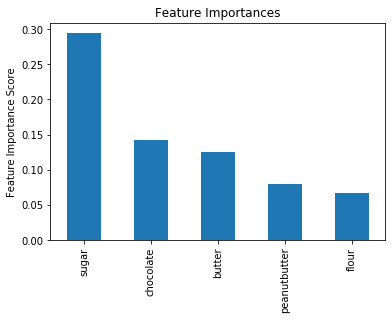

In [282]:
from sklearn.ensemble import GradientBoostingRegressor
mid_model = GradientBoostingRegressor(loss="ls")
modelfit(mid_model, ingredient_bow_train, y_train['totalCal'],bow_transformer)

### Hyperparameter tuning
#### Fix learning rate & Number of estimators for tuning tree-based parameters
`min_samples_split` should be 0.5-1% of the total dataset
`min_samples_leaf`should be ~1/10th of `min_samples_split`
`learning rate` standard is 0.1. Can go up to 0.3.
`n_estimators` should be < 100.

If optimal estimators is around 20, lower learning rate to 0.05 and rerun grid search.
If optimal estimators is too high (~100), increase learning rate. This will cause tuning of other parameters to take a long time.

In [289]:
from sklearn.model_selection import GridSearchCV
param_test1 = {'n_estimators':range(20,241,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.4, min_samples_split=20, min_samples_leaf=2, max_depth=8, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test1, scoring='neg_root_mean_squared_error', n_jobs=4,cv=5)
gsearch1.fit(ingredient_bow_train, y_train['totalCal'])

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.4,
                                                 loss='ls', max_depth=8,
                                                 max_features='sqrt',
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=2,
                                                 min_samples_split=20,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_no_change=None,
              

In [290]:
# gsearch1.cv_results_, 
gsearch1.best_params_, gsearch1.best_score_ # Output

({'n_estimators': 100}, -967.5209634198148)

#### Tune tree parameters

In [294]:
param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(2000,2001,200)}
gsearch2 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.4, n_estimators=100, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test2, scoring='neg_root_mean_squared_error', n_jobs=4, cv=5)
gsearch2.fit(ingredient_bow_train, y_train['totalCal'])
gsearch2.best_params_, gsearch2.best_score_

/Users/jinnysun/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'max_depth': 15, 'min_samples_split': 1020}, -916.7802799284967)

In [297]:
param_test3 = {'min_samples_split':range(900,1200,10), 'min_samples_leaf':range(2,82,4)}
gsearch3 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.4, n_estimators=100, max_depth=7, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test3, scoring='neg_root_mean_squared_error', n_jobs=4, cv=5)
gsearch3.fit(ingredient_bow_train, y_train['totalCal'])
gsearch3.best_params_, gsearch3.best_score_

({'min_samples_leaf': 6, 'min_samples_split': 950}, -915.9444738772884)

In [301]:
param_test4 = {'max_features':range(7,30,2)}
gsearch4 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.4, n_estimators=100, max_depth=7, min_samples_split=950, min_samples_leaf=6, subsample=0.8, random_state=10),
param_grid = param_test4, scoring='neg_root_mean_squared_error', n_jobs=4, cv=5)
gsearch4.fit(ingredient_bow_train, y_train['totalCal'])
gsearch4.best_params_, gsearch4.best_score_

({'max_features': 21}, -912.2919604912142)


Model Report
Slope:  1.01
Intercept:  -23.0
Coefficient of Determinant:  0.83
p-value:  0.0
Standard Error:  0.01
RMSE: 719.02
CV Score : Mean - -912.292 | Std - 70.36446 | Min - -1031.953 | Max - -810.7183
                 coeff
chocolate     0.144125
sugar         0.137306
butter        0.089104
flour         0.082896
peanutbutter  0.068653


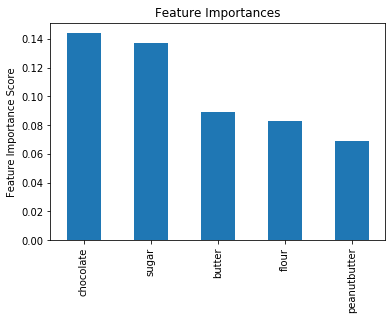

In [302]:
modelfit(gsearch4.best_estimator_, ingredient_bow_train, y_train['totalCal'],bow_transformer)

#### Tune subsample

In [305]:
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.4, n_estimators=100, max_depth=7, min_samples_split=950, min_samples_leaf=6, subsample=0.8, max_features=21, random_state=10),
param_grid = param_test5, scoring='neg_root_mean_squared_error', n_jobs=4, cv=5)
gsearch5.fit(ingredient_bow_train, y_train['totalCal'])
gsearch5.best_params_, gsearch5.best_score_

({'subsample': 0.8}, -912.2919604912142)

#### Make models with lower learning rate


Model Report
Slope:  1.02
Intercept:  -91.0
Coefficient of Determinant:  0.85
p-value:  0.0
Standard Error:  0.01
RMSE: 688.29
CV Score : Mean - -900.8269 | Std - 61.87651 | Min - -1011.295 | Max - -819.4469
                 coeff
sugar         0.145868
chocolate     0.134723
butter        0.095861
flour         0.079627
peanutbutter  0.062760


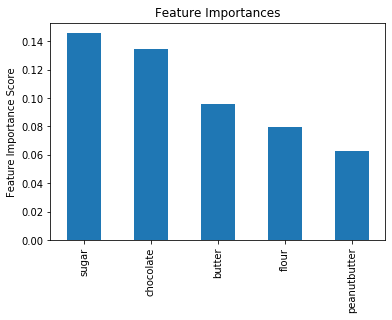

In [306]:
# 1/2 learning rate with 2X trees (n_estimators)
gbm_tuned_1 = GradientBoostingRegressor(learning_rate=0.2, n_estimators=200, max_depth=7, min_samples_split=950, min_samples_leaf=6, subsample=0.8, max_features=21, random_state=10)
modelfit(gbm_tuned_1, ingredient_bow_train, y_train['totalCal'],bow_transformer)


Model Report
Slope:  1.03
Intercept:  -151.0
Coefficient of Determinant:  0.85
p-value:  0.0
Standard Error:  0.01
RMSE: 680.43
CV Score : Mean - -894.823 | Std - 62.09711 | Min - -1005.351 | Max - -813.1289
                 coeff
sugar         0.147271
chocolate     0.118929
butter        0.111587
flour         0.077817
peanutbutter  0.063836


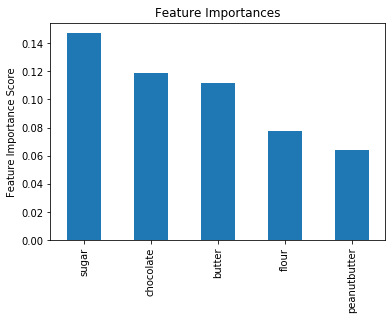

In [308]:
# 1/10 learning rate with 10X trees (n_estimators)
gbm_tuned_2 = GradientBoostingRegressor(learning_rate=0.04, n_estimators=1000, max_depth=7, min_samples_split=950, min_samples_leaf=6, subsample=0.8, max_features=21, random_state=10)
modelfit(gbm_tuned_2, ingredient_bow_train, y_train['totalCal'],bow_transformer)


Model Report
Slope:  1.03
Intercept:  -151.0
Coefficient of Determinant:  0.86
p-value:  0.0
Standard Error:  0.01
RMSE: 671.32
CV Score : Mean - -890.8552 | Std - 59.4808 | Min - -993.9217 | Max - -807.9812
                 coeff
sugar         0.146046
chocolate     0.115842
butter        0.112530
flour         0.076339
peanutbutter  0.064908


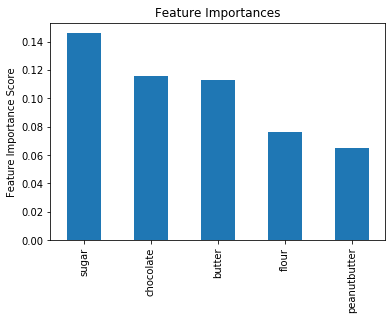

In [310]:
# 1/15 learning rate with 15X trees (n_estimators)
gbm_tuned_3 = GradientBoostingRegressor(learning_rate=0.03, n_estimators=1500, max_depth=7, min_samples_split=950, min_samples_leaf=6, subsample=0.8, max_features=21, random_state=10)
modelfit(gbm_tuned_3, ingredient_bow_train, y_train['totalCal'],bow_transformer)

#### Final model - predict using test data

In [311]:
mid_model = GradientBoostingRegressor(loss="ls", learning_rate=0.03, n_estimators=1500, max_depth=7, min_samples_split=950, min_samples_leaf=6, subsample=0.8, max_features=21, random_state=10)
mid_model.fit(ingredient_bow_train, y_train['totalCal'])
predictions = pd.DataFrame(y_test['totalCal'])
predictions['mid'] = mid_model.predict(ingredient_bow_test)
predictions

,totalCal,mid
key,,
9177,8400.0,6686.444941
9440,6720.0,5348.714797
9471,4880.0,3866.579887
9520,2232.0,2973.945128
9547,6456.0,4972.156115
...,...,...
261182,2352.0,1293.135310
266755,5544.0,5570.551359
267402,2080.0,3118.846382


Text(0, 0.5, 'Predictions')

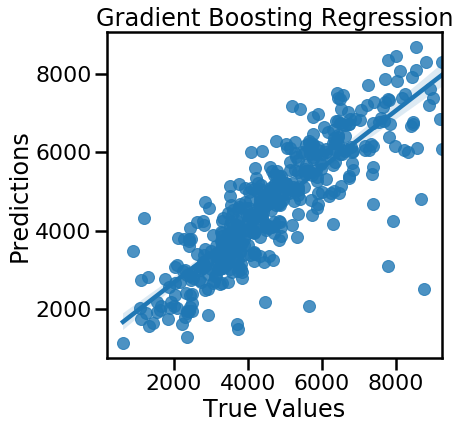

In [312]:
# correlation between true and predicted calories
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster', font_scale=1)

fig = plt.figure(figsize=(6,6))
ax = sns.regplot(y_test['totalCal'],predictions['mid'])
ax.set_title('Gradient Boosting Regression')
ax.set_xlabel('True Values')
ax.set_ylabel('Predictions')

In [313]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(predictions['mid'],y_test['totalCal'])

print('Slope: ', round(slope,2))
print('Intercept: ', round(intercept))
print('Coefficient of Determinant: ', round(r_value**2,2))
print('p-value: ', p_value)
print('Standard Error: ', round(std_err,2)) # standard error of the slope

Slope:  0.99
Intercept:  105.0
Coefficient of Determinant:  0.72
p-value:  8.564637292960531e-128
Standard Error:  0.03


In [326]:
from sklearn import metrics
print('MAE:', round(metrics.mean_absolute_error(y_test['totalCal'], predictions['mid']),2))
print('MSE:', round(metrics.mean_squared_error(y_test['totalCal'], predictions['mid']),2))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test['totalCal'], predictions['mid'])),2))
metrics.r2_score(y_test['totalCal'],predictions['mid']) # this r2 is not representative of a normal r2 since it can be negative

MAE: 646.19
MSE: 873767.77
RMSE: 934.76


0.7192316309847884

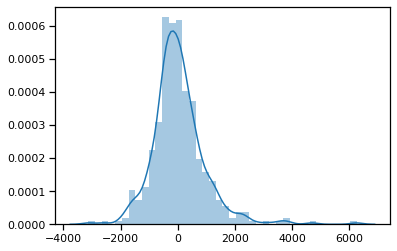

In [314]:
# residual plot - if normally distributed, then this model is good. otherwise, should not use linear prediction model
sns.set_context('notebook', font_scale=1)

sns.distplot(y_test['totalCal']-predictions['mid'])

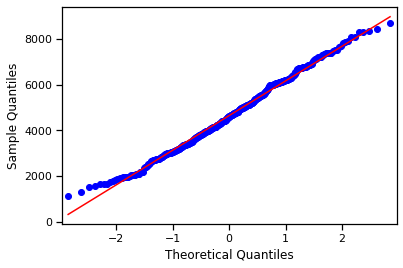

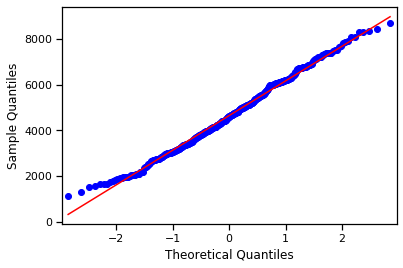

In [315]:
# Using statsmodels
import statsmodels.api as sm
sm.qqplot(predictions['mid'], line='s')

### Gradient Boosting Regressor - orig code

In [316]:
from sklearn.ensemble import GradientBoostingRegressor
# Set lower and upper quantile
LOWER_ALPHA = 0.25
UPPER_ALPHA = 0.75
# Create separate models for lower, median, and upper quantile values
lower_model = GradientBoostingRegressor(loss="quantile", alpha=LOWER_ALPHA, learning_rate=0.03, n_estimators=1500, max_depth=7, min_samples_split=950, min_samples_leaf=6, subsample=0.8, max_features=21, random_state=10)
mid_model = GradientBoostingRegressor(loss="ls", learning_rate=0.03, n_estimators=1500, max_depth=7, min_samples_split=950, min_samples_leaf=6, subsample=0.8, max_features=21, random_state=10)
upper_model = GradientBoostingRegressor(loss="quantile", alpha=UPPER_ALPHA, learning_rate=0.03, n_estimators=1500, max_depth=7, min_samples_split=950, min_samples_leaf=6, subsample=0.8, max_features=21, random_state=10)
# Fit models
lower_model.fit(ingredient_bow_train, y_train['totalCal'])
mid_model.fit(ingredient_bow_train, y_train['totalCal'])
upper_model.fit(ingredient_bow_train, y_train['totalCal'])
# Record actual values on test set
predictions = pd.DataFrame(y_test['totalCal'])
# Predict
predictions['lower'] = lower_model.predict(ingredient_bow_test)
predictions['mid'] = mid_model.predict(ingredient_bow_test)
predictions['upper'] = upper_model.predict(ingredient_bow_test)
predictions['accuracy'] = ((predictions['totalCal'] > predictions['lower']) & ((predictions['totalCal'] < predictions['upper']))).astype(int)
print(round(predictions['accuracy'].mean(),2))
predictions

0.41


,totalCal,lower,mid,upper,accuracy
key,,,,,
9177,8400.0,6205.517953,6686.444941,6984.681007,0
9440,6720.0,5182.286142,5348.714797,5790.595014,0
9471,4880.0,3435.495210,3866.579887,3921.380532,0
9520,2232.0,2674.827371,2973.945128,3679.960304,0
9547,6456.0,4913.424548,4972.156115,5400.998265,0
...,...,...,...,...,...
261182,2352.0,1050.436923,1293.135310,2036.822999,0
266755,5544.0,5293.918519,5570.551359,5802.380424,1
267402,2080.0,2276.060352,3118.846382,3673.913423,0


In [317]:
coeff_words = pd.DataFrame(lower_model.feature_importances_,bow_transformer.get_feature_names(), columns=['coeff_lower'])
coeff_words['coeff_mid'] = mid_model.feature_importances_
coeff_words['coeff_upper'] = upper_model.feature_importances_

In [318]:
len(coeff_words[coeff_words['coeff_mid']==0]) # number of features removed

264

In [319]:
coeff_words['coeff_mid'].sort_values(ascending=False)

sugar              0.146046
chocolate          0.115842
butter             0.112530
flour              0.076339
peanutbutter       0.064908
                     ...   
himalayansalt      0.000000
hersheycinnamon    0.000000
hazelnutliqueur    0.000000
hazelnutalmond     0.000000
eggnog             0.000000
Name: coeff_mid, Length: 372, dtype: float64

In [320]:
coeff_words.loc[['sugar','flour','butter','salt','chocolate']]

,coeff_lower,coeff_mid,coeff_upper
sugar,0.109045,0.146046,0.080566
flour,0.088690,0.076339,0.053506
butter,0.114800,0.112530,0.084681
salt,0.032464,0.046709,0.018393
chocolate,0.064639,0.115842,0.087407


Text(0, 0.5, 'Predictions')

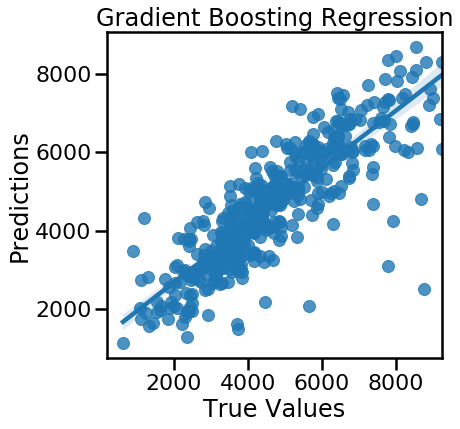

In [321]:
# correlation between true and predicted calories
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster', font_scale=1)

fig = plt.figure(figsize=(6,6))
ax = sns.regplot(y_test['totalCal'],predictions['mid'])
ax.set_title('Gradient Boosting Regression')
ax.set_xlabel('True Values')
ax.set_ylabel('Predictions')

In [322]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(predictions['mid'],y_test['totalCal'])

print('Slope: ', round(slope,2))
print('Intercept: ', round(intercept))
print('Coefficient of Determinant: ', round(r_value**2,2))
print('p-value: ', p_value)
print('Standard Error: ', round(std_err,2)) # standard error of the slope

Slope:  0.99
Intercept:  105.0
Coefficient of Determinant:  0.72
p-value:  8.564637292960531e-128
Standard Error:  0.03


In [323]:
predictions

,totalCal,lower,mid,upper,accuracy
key,,,,,
9177,8400.0,6205.517953,6686.444941,6984.681007,0
9440,6720.0,5182.286142,5348.714797,5790.595014,0
9471,4880.0,3435.495210,3866.579887,3921.380532,0
9520,2232.0,2674.827371,2973.945128,3679.960304,0
9547,6456.0,4913.424548,4972.156115,5400.998265,0
...,...,...,...,...,...
261182,2352.0,1050.436923,1293.135310,2036.822999,0
266755,5544.0,5293.918519,5570.551359,5802.380424,1
267402,2080.0,2276.060352,3118.846382,3673.913423,0


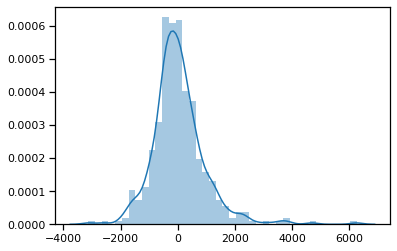

In [324]:
# residual plot - if normally distributed, then this model is good. otherwise, should not use linear prediction model
sns.set_context('notebook', font_scale=1)

sns.distplot(y_test['totalCal']-predictions['mid'])

In [325]:
from sklearn import metrics
print('MAE:', round(metrics.mean_absolute_error(y_test['totalCal'], predictions['mid']),2))
print('MSE:', round(metrics.mean_squared_error(y_test['totalCal'], predictions['mid']),2))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test['totalCal'], predictions['mid'])),2))
metrics.r2_score(y_test['totalCal'],predictions['mid']) # this r2 is not representative of a normal r2 since it can be negative

MAE: 646.19
MSE: 873767.77
RMSE: 934.76


0.7192316309847884

In [ ]:
# Using statsmodels
import statsmodels.api as sm
sm.qqplot(predictions['mid'], line='s')

# Linear Regression

### Pipeline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer # Bag of Words
from sklearn.feature_extraction.text import TfidfTransformer # TF-IDF
from sklearn.linear_model import LinearRegression
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
#    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', LinearRegression(fit_intercept=False)),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

pipeline.fit(X_train['ingredient'],y_train['totalCal']) # Fit Model using training data
predictions = pipeline.predict(X_test['ingredient']) # Predict using test data
print(predictions)

### Separate steps
For plotting predicted vs. true values, Linear Regression with fit_intercept=True provies the best results (2X better R2, slope, etc. if fitting intercept vs. not fitting intercept).

In [ ]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(ingredient_bow_train,y_train['totalCal'])

predictions = linreg.predict(ingredient_bow_test)
predictions

In [ ]:
predictions/

In [ ]:
y_test['predictions'] = predictions
y_test['predictions'].sort_values()

In [ ]:
coeff_words = pd.DataFrame(linreg.coef_,bow_transformer.get_feature_names(), columns=['Coeff'])
coeff_words['Coeff'].sort_values(ascending=False)

In [ ]:
coeff_words.loc[['sugar','flour','butter','salt','chocolate']]

In [ ]:
from sklearn import metrics
print('MAE:', round(metrics.mean_absolute_error(y_test['totalCal'], predictions),2))
print('MSE:', round(metrics.mean_squared_error(y_test['totalCal'], predictions),2))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test['totalCal'], predictions)),2))
metrics.r2_score(y_test['totalCal'],predictions) # this r2 is not representative of a normal r2 since it can be negative

In [ ]:
# correlation between true and predicted calories
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster', font_scale=1)

fig = plt.figure(figsize=(6,6))
ax = sns.regplot(y_test['totalCal'],predictions)
# ax.set_title('Linear Regression')
ax.set_xlabel('True Values')
ax.set_ylabel('Predictions')

In [ ]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(predictions,y_test['totalCal'])

print('Slope: ', round(slope,2))
print('Intercept: ', round(intercept))
print('Coefficient of Determinant: ', round(r_value**2,2))
print('p-value: ', p_value)
print('Standard Error: ', round(std_err,2)) # standard error of the slope

#### Residual plot

In [ ]:
# residual plot - if normally distributed, then this model is good. otherwise, should not use linear prediction model
sns.set_context('notebook', font_scale=1)

sns.distplot(y_test['totalCal']-predictions)

#### QQ Plot

In [ ]:
import scipy.stats as stats
stats.probplot(predictions,dist='norm',plot=plt)

In [ ]:
# Using statsmodels
import statsmodels.api as sm
sm.qqplot(predictions, line='s')

### Cross validation and stats using statsmodel is better than sklearn

In [ ]:
# Cross validation
from sklearn.model_selection import cross_validate
prediction = cross_validate(linreg,ingredient_bow_test,y_test['totalCal'],cv=10)

# from sklearn.metrics, but r2 is not the same since it can be negative
scoring = ['r2', 'explained_variance','max_error','neg_root_mean_squared_error']
prediction2 = cross_validate(linreg,ingredient_bow_test,y_test['totalCal'],cv=10,scoring=scoring)
prediction2

# Data visualization

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams["patch.force_edgecolor"] = True # Always plot edges on bar plots using matplotlib

In [ ]:
ax = df['calPerServing'].plot(kind='hist',ylim=(0,500),bins=20)
ax.set_xlabel('Calories per Serving')
ax.set_ylabel('Number of Recipes')

In [ ]:
sns.distplot(clean_df['totalCal'],kde=False,bins=25)

In [ ]:
sns.distplot(df['servings'])

In [ ]:
sns.regplot(x='servings', y='calPerServing', data=clean_df)

In [ ]:
fig = plt.figure()
word = 'butter'
ax = sns.scatterplot(clean_df[clean_df['ingredient']==word]['norm_quant'],clean_df[clean_df['ingredient']==word]['totalCal'])
ax.set_xlim(0,2000)